In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score
import os
from PIL import Image

# ----------------------------
# Parameters
# ----------------------------
data_dir = 'dataset_samples/'
num_classes = 10 
batch_size = 16
num_epochs = 7
learning_rate = 0.001
patience = 3    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ----------------------------
# Data Loading with Transforms
# ----------------------------
class AmharicDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.samples = []
        self.labels = []
        self.transform = transform
        
        class_names = sorted([d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))])
        self.class_to_idx = {name: i for i, name in enumerate(class_names)}
        
        for class_name in class_names:
            class_path = os.path.join(folder, class_name)
            idx = self.class_to_idx[class_name]
            for file_name in os.listdir(class_path):
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append(os.path.join(class_path, file_name))
                    self.labels.append(idx)
        
    def __len__(self): return len(self.samples)
    
    def __getitem__(self, idx):
        img = Image.open(self.samples[idx]).convert('RGB') # Use RGB for standard CNNs
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

# Standard normalization
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = AmharicDataset(os.path.join(data_dir, 'train'), transform=data_transforms)
val_dataset = AmharicDataset(os.path.join(data_dir, 'val'), transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ----------------------------
# CNN Model
# ----------------------------
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # Stability
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5), # High dropout for small data
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

model = ImprovedCNN(num_classes=num_classes).to(device)

# ----------------------------
# Optimizer & Scheduler
# ----------------------------
criterion = nn.CrossEntropyLoss()
# Added Weight Decay (L2 Regularization)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# Reduces LR by half if Val Loss doesn't improve for 2 epochs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# ----------------------------
# Training Loop
# ----------------------------
def train_loop():
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        train_preds, train_labels = [], []
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_loss /= len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)
        train_acc = accuracy_score(train_labels, train_preds)
        
        # Step the scheduler
        scheduler.step(val_loss)

        print(f"Ep {epoch+1} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f} | Val Loss: {val_loss:.4f}")

        # Early Stopping & Checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early Stopping Triggered")
                break

train_loop()

Ep 1 | Train Acc: 0.542 | Val Acc: 0.801 | Val Loss: 0.5797
Ep 2 | Train Acc: 0.696 | Val Acc: 0.806 | Val Loss: 0.5218
Ep 3 | Train Acc: 0.758 | Val Acc: 0.873 | Val Loss: 0.4293
Ep 4 | Train Acc: 0.801 | Val Acc: 0.885 | Val Loss: 0.3329
Ep 5 | Train Acc: 0.832 | Val Acc: 0.909 | Val Loss: 0.3396
Ep 6 | Train Acc: 0.863 | Val Acc: 0.909 | Val Loss: 0.3235
Ep 7 | Train Acc: 0.891 | Val Acc: 0.930 | Val Loss: 0.2765


Classification Report:
              precision    recall  f1-score   support

          be       0.86      0.72      0.78        68
          ha       0.83      0.83      0.83        63
         hha       0.73      0.83      0.77        52
          le       0.63      0.59      0.61        63
          me       1.00      0.59      0.74        49
          qe       0.90      0.85      0.88        62
          re       1.00      0.45      0.62        51
          sa       0.43      0.97      0.60        62
          se       0.90      0.88      0.89        52
         sha       0.97      0.65      0.78        52

    accuracy                           0.74       574
   macro avg       0.82      0.74      0.75       574
weighted avg       0.81      0.74      0.75       574



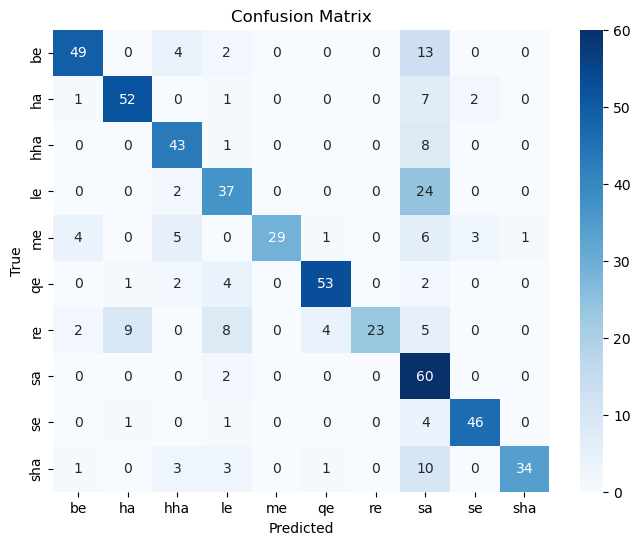

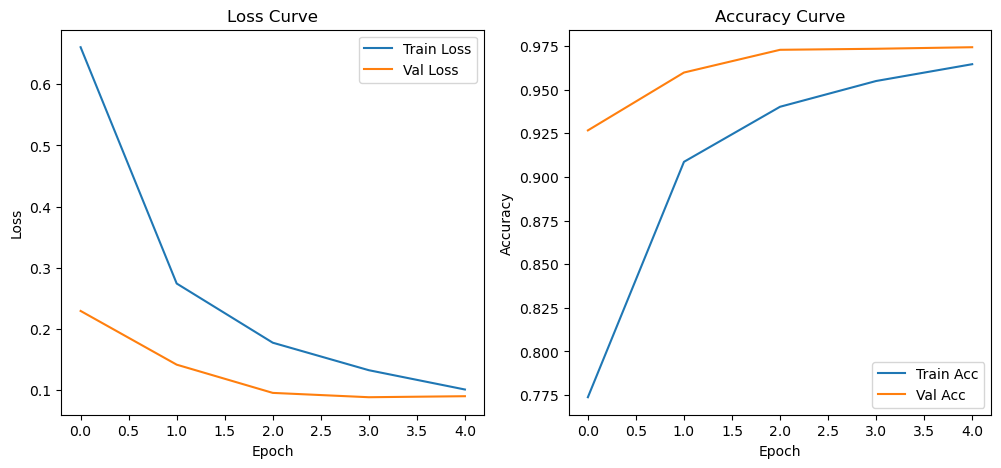

Predicted class: be


In [13]:
# ----------------------------
# EVALUATION & SINGLE IMAGE TEST
# ----------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from PIL import Image

# ----------------------------
# Confusion Matrix & Report
# ----------------------------
model.eval()
preds, trues = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        preds.extend(predicted.cpu().numpy())
        trues.extend(labels.cpu().numpy())

class_names = sorted(train_dataset.class_to_idx.keys())

# Classification report
print("Classification Report:")
print(classification_report(trues, preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(trues, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ----------------------------
# Plot Loss & Accuracy Curves
# ----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

# ----------------------------
# Single Image Prediction
# ----------------------------
def predict_image(model, image_path):
    model.eval()
    img = Image.open(image_path).convert('L').resize((128,128))
    img = np.array(img, dtype=np.float32)/255.0
    img = np.stack([img]*3, axis=0)
    img = torch.tensor(img).unsqueeze(0).to(device)  # batch dimension

    with torch.no_grad():
        output = model(img)
        _, pred = torch.max(output, 1)
    print(f"Predicted class: {class_names[pred.item()]}")

# Example usage:
predict_image(model, 'dataset_samples/test/be/dataset3_form2_1467_orig.png')
